In [1]:
import torch
# Import pipeline and main diffusion components from diffusers
from diffusers import (
    StableDiffusionPipeline,
    UNet2DConditionModel,
    AutoencoderKL,
    DDPMScheduler # Keep these from diffusers
)
# Import CLIP components from transformers
from transformers import CLIPTextModel, CLIPTokenizer
from PIL import Image
import matplotlib.pyplot as plt
import os
import gc # Import garbage collector


'NoneType' object has no attribute 'cadam32bit_grad_fp32'


/Users/udaykiran/Documents/NEU/NLP/Final Project/flickr30k-model/.venv/lib/python3.12/site-packages/bitsandbytes/cextension.py:34: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
  warn("The installed version of bitsandbytes was compiled without GPU support. "


In [2]:
# --------------- Device Selection ---------------
if torch.cuda.is_available():
    device = "cuda"
    # Optionally select a specific GPU if multiple are available
    # gpu_id = 0 # Default to GPU 0 if multiple CUDA devices
    # os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_id)
    # device = f"cuda:{gpu_id}"
    # Make sure to get properties from the correct device index if specifying one
    device_index = torch.cuda.current_device() # Get index of default CUDA device
    print(f"Using GPU: {torch.cuda.get_device_name(device_index)}")
    print(f"Total GPU memory: {torch.cuda.get_device_properties(device_index).total_memory / 1e9:.2f} GB")
elif torch.backends.mps.is_available():
    device = "mps"
    print("Using Apple Silicon MPS")
else:
    device = "cpu"
    print("CUDA and MPS not available, using CPU")

# Helper to free memory
def free_memory():
    gc.collect()
    if device.startswith("cuda"): # Check if device is cuda (e.g. "cuda", "cuda:0")
        torch.cuda.empty_cache()

# --------------- Configuration ---------------
# !!! DEBUGGING STEP: Try float32 first to rule out FP16 issues !!!
# torch_dtype = torch.float16 if device != "cpu" else torch.float32
torch_dtype = torch.float32 # Start with float32 for debugging
print(f"Using dtype: {torch_dtype}")

enable_attention_slicing = True if device != "cpu" else False # Attention slicing might not be needed/optimal on CPU

# Define inference parameters
inference_steps = 30
guidance_scale = 7.5

# Define model paths
base_model_id = "CompVis/stable-diffusion-v1-4"
fine_tuned_unet_id = "dinaaaaaa/flickr30k-fine-tuned-unet" # Using Hugging Face Hub path

# --------------- Load Shared Components (Memory Efficient) ---------------
print("Loading shared components...")
free_memory()
tokenizer = CLIPTokenizer.from_pretrained(base_model_id, subfolder="tokenizer")
print("Tokenizer loaded.")

# Load other components with specified dtype
text_encoder = CLIPTextModel.from_pretrained(
    base_model_id, subfolder="text_encoder", torch_dtype=torch_dtype
).to(device)
print("Text Encoder loaded.")

vae = AutoencoderKL.from_pretrained(
    base_model_id, subfolder="vae", torch_dtype=torch_dtype
).to(device)
print("VAE loaded.")

scheduler = DDPMScheduler.from_pretrained(base_model_id, subfolder="scheduler")
print("Scheduler loaded.")
print("Shared components loaded.")
free_memory()

# --------------- Load U-Nets ---------------
print("Loading U-Nets...")
# Load Original U-Net
original_unet = UNet2DConditionModel.from_pretrained(
    base_model_id, subfolder="unet", torch_dtype=torch_dtype
).to(device)
print("Original UNet loaded.")

# Load Fine-tuned U-Net
try:
    fine_tuned_unet = UNet2DConditionModel.from_pretrained(
        fine_tuned_unet_id, torch_dtype=torch_dtype
    ).to(device)
    print("Fine-tuned UNet loaded.")
except Exception as e:
    print(f"!!! ERROR loading fine-tuned UNet from {fine_tuned_unet_id}: {e} !!!")
    print("Fine-tuned pipeline will likely fail or use original UNet depending on subsequent logic.")
    fine_tuned_unet = None # Indicate failure
free_memory()

# --------------- Assemble Pipelines ---------------
# Check if components loaded successfully before assembly
if vae and text_encoder and tokenizer and original_unet and scheduler:
    print("Assembling original pipeline...")
    original_pipe = StableDiffusionPipeline(
        vae=vae,
        text_encoder=text_encoder,
        tokenizer=tokenizer,
        unet=original_unet,
        scheduler=scheduler,
        safety_checker=None, # Disable safety checker
        feature_extractor=None,
        requires_safety_checker=False,
    )
    # Apply memory optimizations if needed (less critical with float32 perhaps)
    if enable_attention_slicing:
        original_pipe.enable_attention_slicing()
        print("Enabled attention slicing for original pipeline.")
    print("Original pipeline assembled.")
else:
    print("!!! ERROR: Could not assemble original pipeline due to missing components. !!!")
    original_pipe = None

if vae and text_encoder and tokenizer and fine_tuned_unet and scheduler:
    print("Assembling fine-tuned pipeline...")
    fine_tuned_pipe = StableDiffusionPipeline(
        vae=vae,
        text_encoder=text_encoder,
        tokenizer=tokenizer,
        unet=fine_tuned_unet, # Use the fine-tuned UNet here
        scheduler=scheduler,
        safety_checker=None,
        feature_extractor=None,
        requires_safety_checker=False,
    )
    # Apply memory optimizations
    if enable_attention_slicing:
        fine_tuned_pipe.enable_attention_slicing()
        print("Enabled attention slicing for fine-tuned pipeline.")
    print("Fine-tuned pipeline assembled.")
else:
    print("!!! ERROR: Could not assemble fine-tuned pipeline (fine-tuned UNet might be missing). !!!")
    fine_tuned_pipe = None

print("Pipeline assembly step finished.")
free_memory()



Using Apple Silicon MPS
Using dtype: torch.float32
Loading shared components...
Tokenizer loaded.
Text Encoder loaded.
VAE loaded.
Scheduler loaded.
Shared components loaded.
Loading U-Nets...
Original UNet loaded.
Fine-tuned UNet loaded.
Assembling original pipeline...
Enabled attention slicing for original pipeline.
Original pipeline assembled.
Assembling fine-tuned pipeline...
Enabled attention slicing for fine-tuned pipeline.
Fine-tuned pipeline assembled.
Pipeline assembly step finished.


In [3]:
# --------------- Inference and Comparison ---------------

# Test prompt list
test_prompts = [
    "A person walking on the beach",
    "A cat sitting on a windowsill",
    "People on a city street",
    "A cabin in the mountains",
    "A person reading a book"
]

# Generate and compare images
def compare_models(prompts, device):
    """Generates images using original and fine-tuned models and compares them."""
    if not original_pipe and not fine_tuned_pipe:
        print("!!! Both pipelines failed to assemble. Cannot run comparison. !!!")
        return

    for i, prompt in enumerate(prompts):
        print(f"\nProcessing prompt {i+1}/{len(prompts)}: '{prompt}'")

        free_memory() # Clear memory before generating pair

        # Use the same seed for reproducibility and direct comparison
        # Ensure generator is created for the correct device
        try:
            generator = torch.Generator(device=device).manual_seed(42)
        except Exception as e:
            print(f"!!! Error creating torch.Generator for device '{device}': {e} !!!")
            print("Cannot proceed with generation for this prompt.")
            continue # Skip to next prompt

        original_image = None
        fine_tuned_image = None

        # --- Generate image with original model ---
        if original_pipe:
            print("Generating image with original model...")
            try:
                # Ensure generator is reset if previous attempt failed partially
                generator = torch.Generator(device=device).manual_seed(42)
                with torch.inference_mode(): # Use inference mode for efficiency
                    output = original_pipe(
                        prompt,
                        guidance_scale=guidance_scale,
                        num_inference_steps=inference_steps,
                        generator=generator,
                        # Add output_type='pil' for clarity, though it's default
                        output_type='pil'
                    )
                    # Check if NSFW filter was triggered (though disabled, check attribute just in case)
                    # if hasattr(output, 'nsfw_content_detected') and output.nsfw_content_detected is not None and any(output.nsfw_content_detected):
                    #     print("!!! Original Model: Potential NSFW content detected - image might be black/blurred !!!")
                    original_image = output.images[0]

                # Check if image is black
                if original_image and original_image.mode == 'RGB' and original_image.getextrema() == ((0, 0), (0, 0), (0, 0)):
                     print("!!! WARNING: Original model generated a black image. !!!")
                elif original_image:
                     print("Original image generated.")
                else:
                     print("Original model generation failed to produce an image.")

                free_memory() # Free memory after first generation

            except torch.cuda.OutOfMemoryError as e:
                 print(f"\n!!! CUDA Out of Memory error (Original Model) for prompt: '{prompt}' !!!")
                 print(f"Error details: {e}")
                 free_memory() # Attempt to clear memory after OOM
            except Exception as e: # Catch other potential errors
                 print(f"\n!!! An error occurred generating (Original Model) for prompt: '{prompt}' !!!")
                 print(f"Error type: {type(e).__name__}")
                 print(f"Error details: {e}")
                 free_memory() # Attempt to clear memory after other errors
        else:
            print("Skipping original model generation (pipeline not available).")


        # --- Generate image with fine-tuned model ---
        if fine_tuned_pipe:
             print("Generating image with fine-tuned model...")
             try:
                # Reset generator with the same seed
                generator = torch.Generator(device=device).manual_seed(42)
                with torch.inference_mode():
                    output = fine_tuned_pipe(
                        prompt,
                        guidance_scale=guidance_scale,
                        num_inference_steps=inference_steps,
                        generator=generator,
                        output_type='pil'
                    )
                    # if hasattr(output, 'nsfw_content_detected') and output.nsfw_content_detected is not None and any(output.nsfw_content_detected):
                    #     print("!!! Fine-tuned Model: Potential NSFW content detected - image might be black/blurred !!!")
                    fine_tuned_image = output.images[0]

                # Check if image is black
                if fine_tuned_image and fine_tuned_image.mode == 'RGB' and fine_tuned_image.getextrema() == ((0, 0), (0, 0), (0, 0)):
                     print("!!! WARNING: Fine-tuned model generated a black image. !!!")
                elif fine_tuned_image:
                     print("Fine-tuned image generated.")
                else:
                     print("Fine-tuned model generation failed to produce an image.")

             except torch.cuda.OutOfMemoryError as e:
                 print(f"\n!!! CUDA Out of Memory error (Fine-tuned Model) for prompt: '{prompt}' !!!")
                 print(f"Error details: {e}")
                 free_memory() # Attempt to clear memory after OOM
             except Exception as e: # Catch other potential errors
                 print(f"\n!!! An error occurred generating (Fine-tuned Model) for prompt: '{prompt}' !!!")
                 print(f"Error type: {type(e).__name__}")
                 print(f"Error details: {e}")
                 free_memory() # Attempt to clear memory after other errors
        else:
             print("Skipping fine-tuned model generation (pipeline not available).")


        # --- Display results ---
        if original_image or fine_tuned_image: # Display if at least one image was generated
            plt.figure(figsize=(16, 8))

            plt.subplot(1, 2, 1)
            if original_image:
                plt.imshow(original_image)
                plt.title("Original Model")
            else:
                plt.text(0.5, 0.5, 'Generation Failed / Skipped', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
                plt.title("Original Model (Failed)")
            plt.axis("off")

            plt.subplot(1, 2, 2)
            if fine_tuned_image:
                plt.imshow(fine_tuned_image)
                plt.title("Fine-tuned Model")
            else:
                plt.text(0.5, 0.5, 'Generation Failed / Skipped', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
                plt.title("Fine-tuned Model (Failed)")
            plt.axis("off")

            plt.suptitle(f"Prompt: '{prompt}'", fontsize=16)
            plt.tight_layout()
            plt.show() # Keep for Jupyter environment

            # --- Save images ---
            output_dir = "comparison_outputs"
            os.makedirs(output_dir, exist_ok=True)
            sanitized_prompt = "".join(c if c.isalnum() else "_" for c in prompt)[:50]
            if original_image:
                original_filename = os.path.join(output_dir, f"cmp_{i}_{sanitized_prompt}_orig.png")
                original_image.save(original_filename)
                print(f"Saved original image to '{original_filename}'")
            if fine_tuned_image:
                finetuned_filename = os.path.join(output_dir, f"cmp_{i}_{sanitized_prompt}_fine.png")
                fine_tuned_image.save(finetuned_filename)
                print(f"Saved fine-tuned image to '{finetuned_filename}'")
        else:
             print("No images generated for this prompt to display or save.")




Starting comparison...

Processing prompt 1/5: 'A person walking on the beach'
Generating image with original model...


  0%|          | 0/30 [00:00<?, ?it/s]

Original image generated.
Generating image with fine-tuned model...


  0%|          | 0/30 [00:00<?, ?it/s]

Fine-tuned image generated.


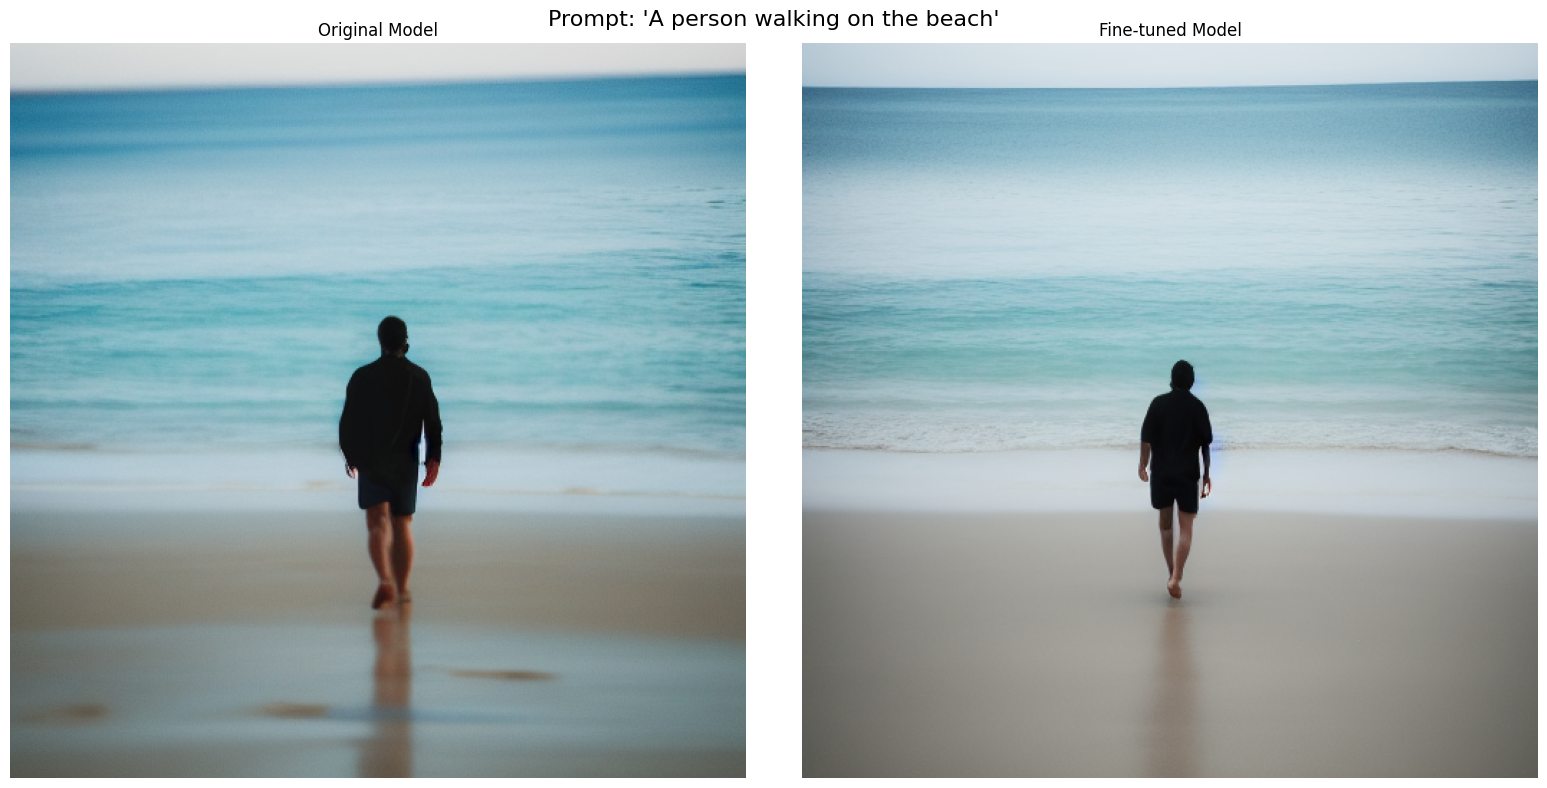

Saved original image to 'comparison_outputs/cmp_0_A_person_walking_on_the_beach_orig.png'
Saved fine-tuned image to 'comparison_outputs/cmp_0_A_person_walking_on_the_beach_fine.png'

Processing prompt 2/5: 'A cat sitting on a windowsill'
Generating image with original model...


  0%|          | 0/30 [00:00<?, ?it/s]

Original image generated.
Generating image with fine-tuned model...


  0%|          | 0/30 [00:00<?, ?it/s]

Fine-tuned image generated.


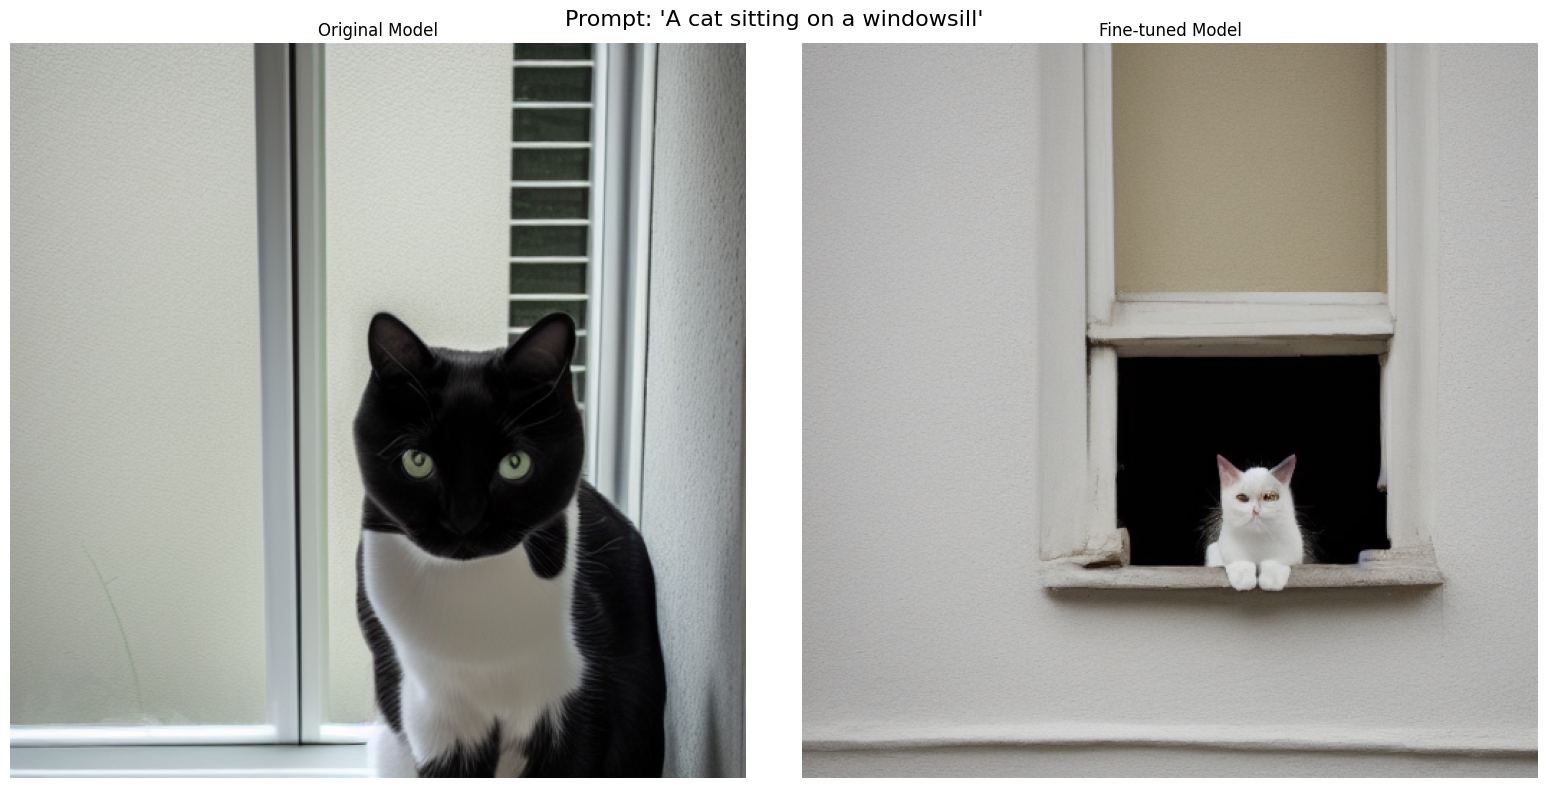

Saved original image to 'comparison_outputs/cmp_1_A_cat_sitting_on_a_windowsill_orig.png'
Saved fine-tuned image to 'comparison_outputs/cmp_1_A_cat_sitting_on_a_windowsill_fine.png'

Processing prompt 3/5: 'People on a city street'
Generating image with original model...


  0%|          | 0/30 [00:00<?, ?it/s]

Original image generated.
Generating image with fine-tuned model...


  0%|          | 0/30 [00:00<?, ?it/s]

Fine-tuned image generated.


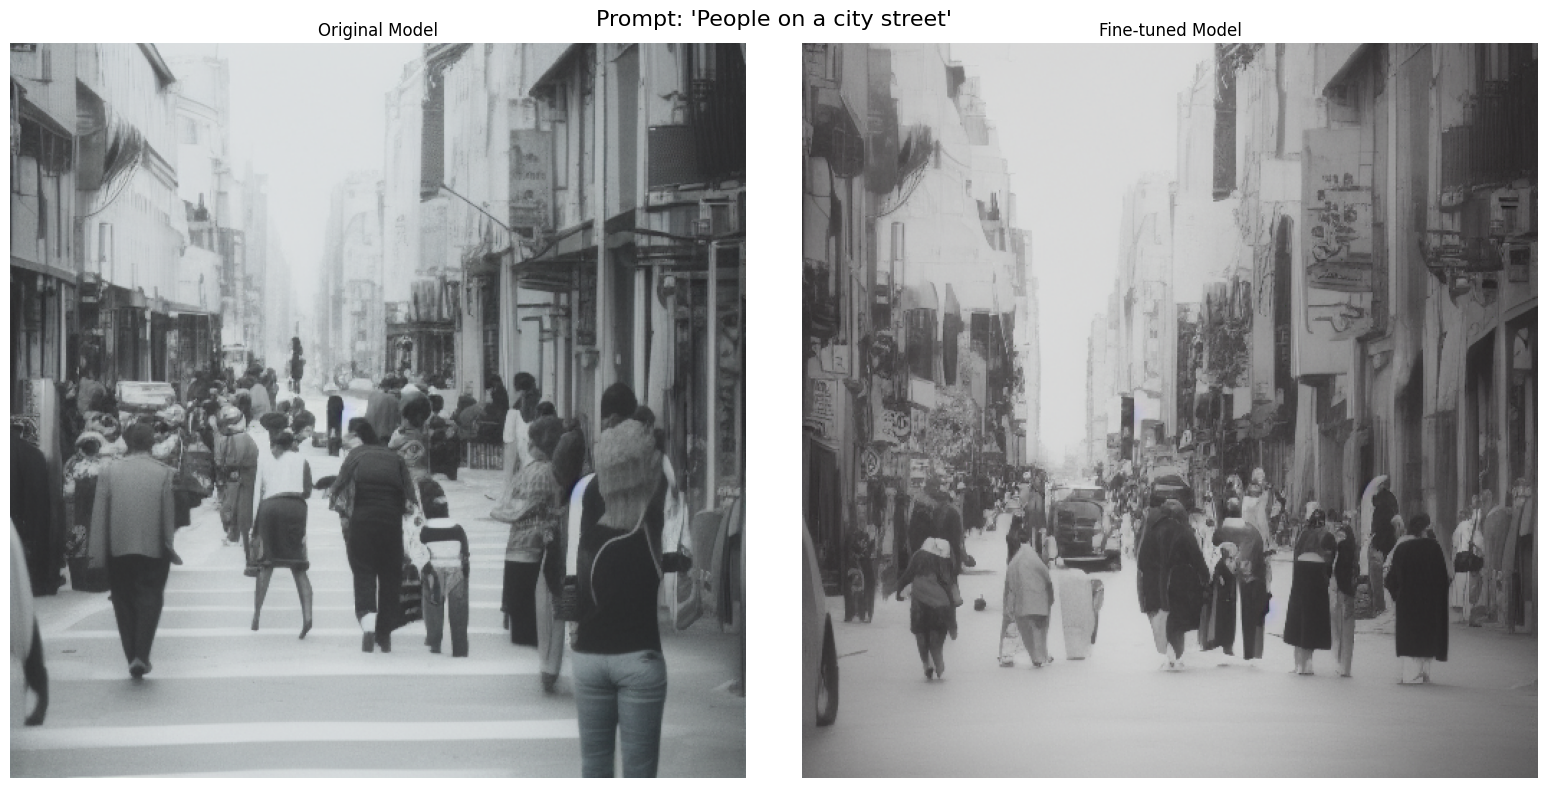

Saved original image to 'comparison_outputs/cmp_2_People_on_a_city_street_orig.png'
Saved fine-tuned image to 'comparison_outputs/cmp_2_People_on_a_city_street_fine.png'

Processing prompt 4/5: 'A cabin in the mountains'
Generating image with original model...


  0%|          | 0/30 [00:00<?, ?it/s]

Original image generated.
Generating image with fine-tuned model...


  0%|          | 0/30 [00:00<?, ?it/s]

Fine-tuned image generated.


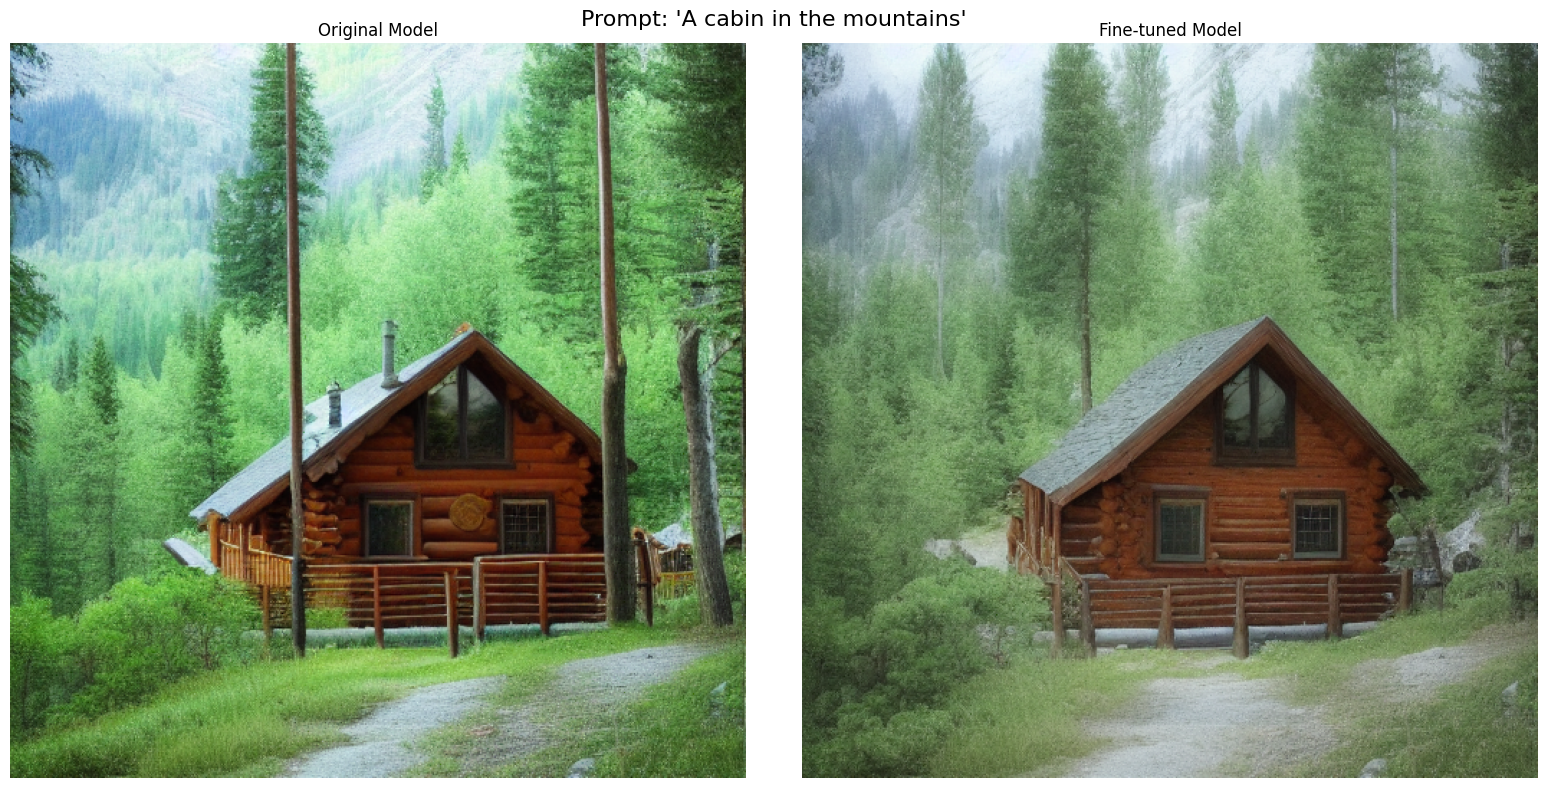

Saved original image to 'comparison_outputs/cmp_3_A_cabin_in_the_mountains_orig.png'
Saved fine-tuned image to 'comparison_outputs/cmp_3_A_cabin_in_the_mountains_fine.png'

Processing prompt 5/5: 'A person reading a book'
Generating image with original model...


  0%|          | 0/30 [00:00<?, ?it/s]

Original image generated.
Generating image with fine-tuned model...


  0%|          | 0/30 [00:00<?, ?it/s]

Fine-tuned image generated.


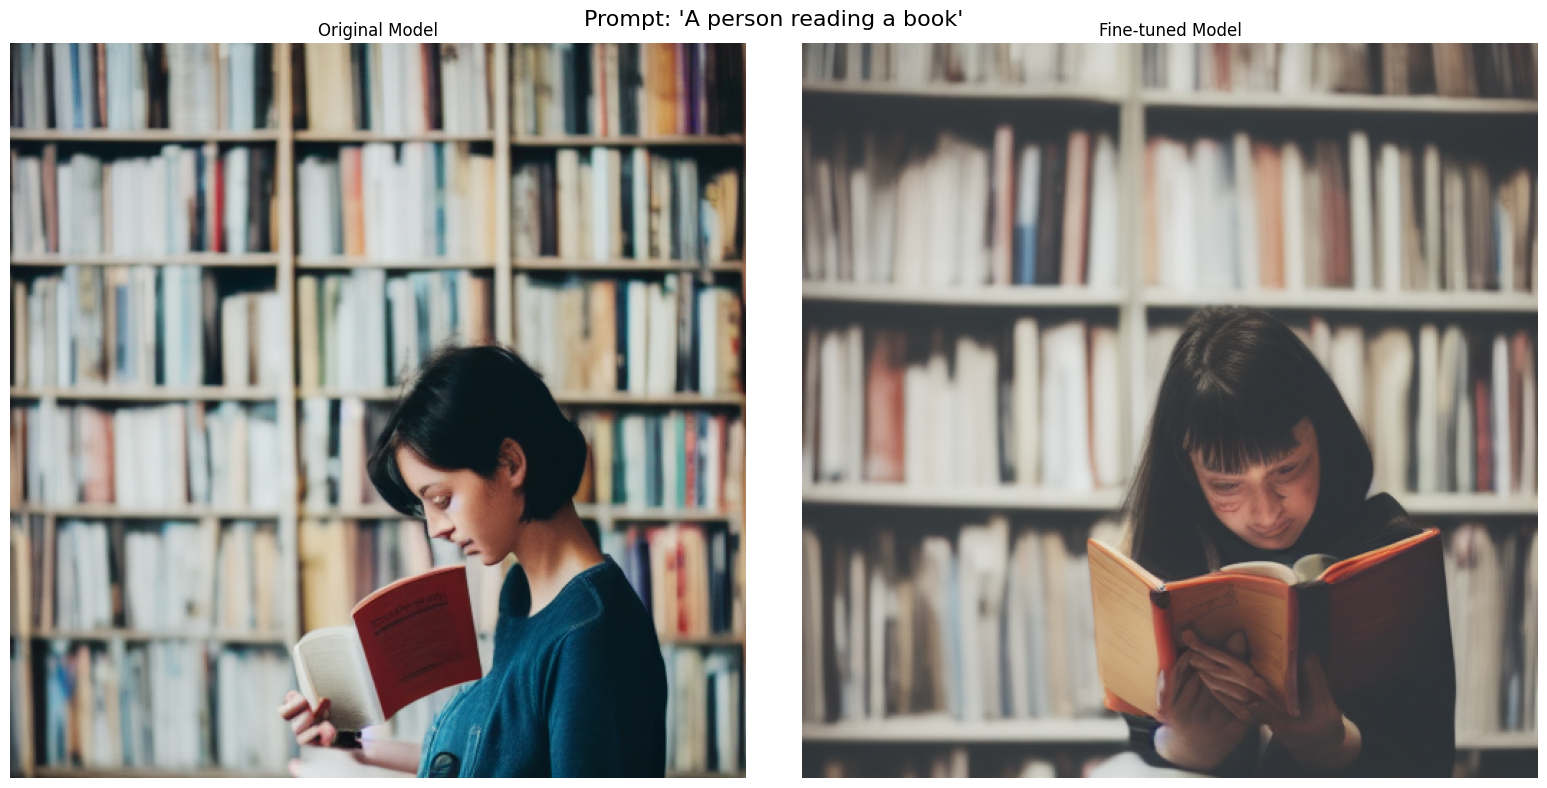

Saved original image to 'comparison_outputs/cmp_4_A_person_reading_a_book_orig.png'
Saved fine-tuned image to 'comparison_outputs/cmp_4_A_person_reading_a_book_fine.png'

Comparison finished.


In [4]:
# --------------- Execution ---------------
print("\nStarting comparison...")
compare_models(test_prompts, device) # Pass the selected device
print("\nComparison finished.")